In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib import font_manager,rc  #한글 폰트 입력을 위한 라이브러리

#폰트 경로 가져오기
# font_path = 'C:/Users/smcljy/AppData/Local/Microsoft/Windows/Fonts/.ttf'
font_path = 'C:/Windows/Fonts/SGL.ttf' #삼성고딕체
 
# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()
 
#폰트 설정하기
mpl.rc('font',family=font_name)

In [2]:
workdir = ""
file_path = '{}/NUM_DATA.dta'.format(workdir)

data = pd.read_stata(file_path)

# data = pd.merge(data1,data2, on=['ID','ORDR_YMD'], how="left")

# 조건별 그룹 설정

### 정상, 기타 결과 그룹 분리

In [3]:
GRP = 'DYSLIPID'

In [4]:
data.loc[(data['BL3113'] >= 240) | (data['BL314201'] >= 160 ) | (data['BL3141'] >= 200 ) | (data['BL3142'] < 40 ) | (data['TRT_MED_HYPERLIPIDEMIA'] == '1'), GRP] = '이상지질혈증'
# data.loc[(data['BL3164'] >= 6.5) | (data['TRT_MED_DIABETES'] == '1'), GRP] = '당뇨'
data['DYSLIPID'].fillna('정상',inplace=True)

In [5]:
data.loc[data['GEND_CD'] == 'M', 'GENDER'] = '남'
data.loc[data['GEND_CD'] == 'F', 'GENDER'] = '여'

In [6]:
data.loc[ data['AGE'] < 30                      ,'AGEGRP'] = '0~29세'
data.loc[(data['AGE'] > 29) & (data['AGE'] < 40),'AGEGRP'] = '30~39세'
data.loc[(data['AGE'] > 39) & (data['AGE'] < 50),'AGEGRP'] = '40~49세'
data.loc[(data['AGE'] > 49) & (data['AGE'] < 60),'AGEGRP'] = '50~59세'
data.loc[(data['AGE'] > 59) & (data['AGE'] < 70),'AGEGRP'] = '60~69세'
data.loc[ data['AGE'] > 69                      ,'AGEGRP'] = '70세 이상'
# data.head(100)

### 특정 그룹 별도 저장 - 이상지질혈증(Dyslipidemia)은 control군 배제

In [7]:
# dysl_ctrl = data.drop(data.loc[data[GRP]!='당뇨'].index)
# dysl_ctrl.loc[(dysl_ctrl['BL3164'] < 7.0), '{}_CTRL_YN'.format(GRP)] = '조절군'
# dysl_ctrl['{}_CTRL_YN'.format(GRP)].fillna('비조절군',inplace=True)
# dysl_ctrl

In [8]:
data_m = data.drop(data.loc[data['GEND_CD']=='F'].index)
data_f = data.drop(data.loc[data['GEND_CD']=='M'].index)

In [9]:
# data_ctrl_m = dysl_ctrl.drop(dysl_ctrl.loc[dysl_ctrl['GEND_CD']=='F'].index)
# data_ctrl_f = dysl_ctrl.drop(dysl_ctrl.loc[dysl_ctrl['GEND_CD']=='M'].index)

## pivot table create

In [10]:
dysl_cnt_m = data_m.pivot_table(
                             index=[GRP,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# dysl_cnt_m
# dysl_per_m = round(dysl_cnt_m.div(dysl_cnt_m.iloc[-1,-1], axis=0).astype(float)*100,1) # total value
# each column total value percentile
dysl_per_m = round(dysl_cnt_m.div(dysl_cnt_m.iloc[-1], axis=1).astype(float)*100,1)

# dysl_per_m

dysl_agegrp_m = pd.DataFrame()

for i in range(len(dysl_cnt_m.columns)):
    if i == 0:
        dysl_agegrp_m = pd.concat(
                                [
                                 dysl_cnt_m.iloc[:,i]
                                ,dysl_per_m.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_agegrp_m = pd.concat(
                                [
                                 dysl_agegrp_m
                                ,dysl_cnt_m.iloc[:,i]
                                ,dysl_per_m.iloc[:,i]
                                ]
                            ,axis=1
        )
        
# dysl_agegrp_m

In [11]:
dysl_cnt_f = data_f.pivot_table(
                             index=[GRP,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# dysl_cnt_f
# dysl_per_f = round(dysl_cnt_f.div(dysl_cnt_f.iloc[-1,-1], axis=0).astype(float)*100,1) # total value
# each column total value percentile
dysl_per_f = round(dysl_cnt_f.div(dysl_cnt_f.iloc[-1], axis=1).astype(float)*100,1)

# dysl_per_f

dysl_agegrp_f = pd.DataFrame()

for i in range(len(dysl_cnt_f.columns)):
    if i == 0:
        dysl_agegrp_f = pd.concat(
                                [
                                 dysl_cnt_f.iloc[:,i]
                                ,dysl_per_f.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_agegrp_f = pd.concat(
                                [
                                 dysl_agegrp_f
                                ,dysl_cnt_f.iloc[:,i]
                                ,dysl_per_f.iloc[:,i]
                                ]
                            ,axis=1
        )
        
# dysl_agegrp_f

In [12]:
dysl_agegrp = pd.concat([dysl_agegrp_m.iloc[:-1,:], dysl_agegrp_f.iloc[:-1,:]],axis=0)
# dysl_agegrp = pd.concat([dysl_agegrp_m, dysl_agegrp_f],axis=0)
dysl_agegrp_label = []

for i in range(len(dysl_agegrp.columns)):
    dysl_agegrp_label.append(dysl_agegrp.columns[i][1])
    
dysl_agegrp.columns = dysl_agegrp_label
# dysl_agegrp.set_index(dysl_agegrp.index.names,inplace=True)
dysl_agegrp = dysl_agegrp.sort_index()

labels = []
for i in range(len(dysl_per_m.columns)-1):
    labels.append(dysl_per_m.columns[i][1])
    
# dysl_agegrp

In [13]:
dysl_cnt_t = data.pivot_table(
                             index=[GRP]#,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# total value percentile
dysl_per_t = round(dysl_cnt_t.div(dysl_cnt_t.iloc[-1,-1], axis=0).astype(float)*100,1)

dysl_per_t

dysl_agegrp_t = pd.DataFrame()

for i in range(len(dysl_cnt_t.columns)):
    if i == 0:
        dysl_agegrp_t = pd.concat(
                                [
                                 dysl_cnt_t.iloc[:,i]
                                ,dysl_per_t.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_agegrp_t = pd.concat(
                                [
                                 dysl_agegrp_t
                                ,dysl_cnt_t.iloc[:,i]
                                ,dysl_per_t.iloc[:,i]
                                ]
                            ,axis=1
        )

# dysl_agegrp_t

In [14]:
dysl_cnt_subt = data.pivot_table(
                             index=[GRP]#,'GENDER']
                            ,columns=['AGEGRP']
    ,values=['ID']
    ,aggfunc='count'
    ,margins=True
    ,fill_value=0
                            )

# total value percentile
# dysl_per_t = round(dysl_cnt_t.div(dysl_cnt_t.iloc[-1,-1], axis=0).astype(float)*100,1)
# 211123 기준 변경
dysl_per_subt = round(dysl_cnt_subt.div(dysl_cnt_subt.iloc[-1], axis=1).astype(float)*100,1)

dysl_per_subt

dysl_agegrp_subt = pd.DataFrame()

for i in range(len(dysl_cnt_subt.columns)):
    if i == 0:
        dysl_agegrp_subt = pd.concat(
                                [
                                 dysl_cnt_subt.iloc[:,i]
                                ,dysl_per_subt.iloc[:,i]
                                ]
                            ,axis=1
        )
    else:
        dysl_agegrp_subt = pd.concat(
                                [
                                 dysl_agegrp_subt
                                ,dysl_cnt_subt.iloc[:,i]
                                ,dysl_per_subt.iloc[:,i]
                                ]
                            ,axis=1
        )

dysl_agegrp_subt

ID                                                                 \
         0~29세  0~29세 30~39세 30~39세 40~49세 40~49세 50~59세 50~59세 60~69세 60~69세   
DYSLIPID                                                                        
이상지질혈증     125   12.3    796   24.0   2602   31.9   7598   47.9   5662   55.6   
정상         892   87.7   2527   76.0   5553   68.1   8261   52.1   4526   44.4   
All       1017  100.0   3323  100.0   8155  100.0  15859  100.0  10188  100.0   

                                      
         70세 이상 70세 이상    All    All  
DYSLIPID                              
이상지질혈증     1990   56.8  18773   44.7  
정상         1511   43.2  23270   55.3  
All        3501  100.0  42043  100.0

# Bar chart create

No handles with labels found to put in legend.
No handles with labels found to put in legend.


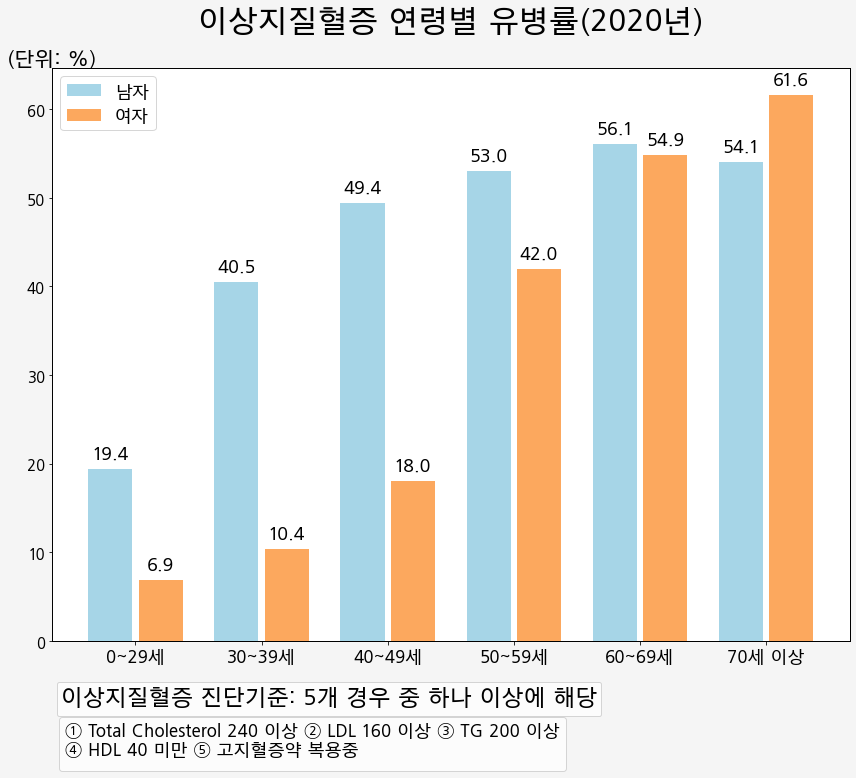

In [18]:
value01 = dysl_per_m.iloc[0,:-1]
value02 = dysl_per_f.iloc[0,:-1]

x = np.arange(len(labels))  # the label locations # all 값이 list에는 포함되지 않았기 때문임.
width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12, 11)) # 캔버스 배경 사이즈 설정

fig.set_facecolor('whitesmoke') ## 캔버스 배경색 설정
rects1 = ax.bar(x - 0.2, value01, width, label='남자',color=plt.get_cmap('RdYlBu')(np.linspace(0.15, 0.85,np.array(dysl_per_m.iloc[0,:-1]).shape[0]))[4])
rects2 = ax.bar(x + 0.2, value02, width, label='여자',color=plt.get_cmap('RdYlBu')(np.linspace(0.15, 0.85,np.array(dysl_per_m.iloc[0,:-1]).shape[0]))[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('이상지질혈증 연령별 유병률(2020년)\n',fontsize=30)
ax.set_ylabel(
                '(단위: %)' # 표시값
                 ,labelpad=-70 # 여백값 설정
                ,fontsize=20 # 글씨크기 설정
                ,rotation=0 # 회전값 조정
#                 ,ha='center' # 위치조정
                ,loc='top' # 위치조정, ha와 동시에 사용은 불가함.
            )
ax.yaxis.set_tick_params(labelsize=15) # y축 표시값 글씨크기 조정
ax.set_xticks(x)
ax.set_xticklabels(
                   labels[0:len(labels)] # all 값이 list에는 포함되지 않았기 때문임.
                  , fontsize=17
                  )

ax.legend(fontsize=17)
# ax.legend(bbox_to_anchor=(0.5,-0.18), title='LEGEND01', title_fontsize = 17 ,ncol=6  ,loc='lower center' ,fontsize=15)

# bar위에 값 label 표시
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(height, 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 8),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom'
                   ,fontsize=18
                   )

autolabel(rects1)
autolabel(rects2)

# multiple legend
def twinx(self):
    ax2 = self._make_twin_axes(sharex=self)
    # ax2.yaxis.tick_right()
    ax2.yaxis.set_visible(False)
    # ax2.yaxis.set_label_position('right')
    # ax2.yaxis.set_offset_position('right')
    ax2.set_autoscalex_on(self.get_autoscalex_on())
    self.yaxis.tick_left()
    ax2.xaxis.set_visible(False)
    ax2.patch.set_visible(False)
    return ax2

ax2 = twinx(ax)
ax3 = twinx(ax)
lg1 = ax2.legend(bbox_to_anchor=(0,-0.14), title='이상지질혈증 진단기준: 5개 경우 중 하나 이상에 해당', title_fontsize = 22 ,ncol=1  ,loc='lower left')
lg2 = ax3.legend(bbox_to_anchor=(0,-0.24), title='① Total Cholesterol 240 이상 ② LDL 160 이상 ③ TG 200 이상\n④ HDL 40 미만 ⑤ 고지혈증약 복용중', title_fontsize = 17 ,ncol=1,loc='lower left' ,fontsize=15)

fig.tight_layout()

plt.savefig("{}/dysl_total_mf.png".format(workdir)
            ,bbox_extra_artists=(lg1,lg2)
            ,bbox_inches='tight'
            )

plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


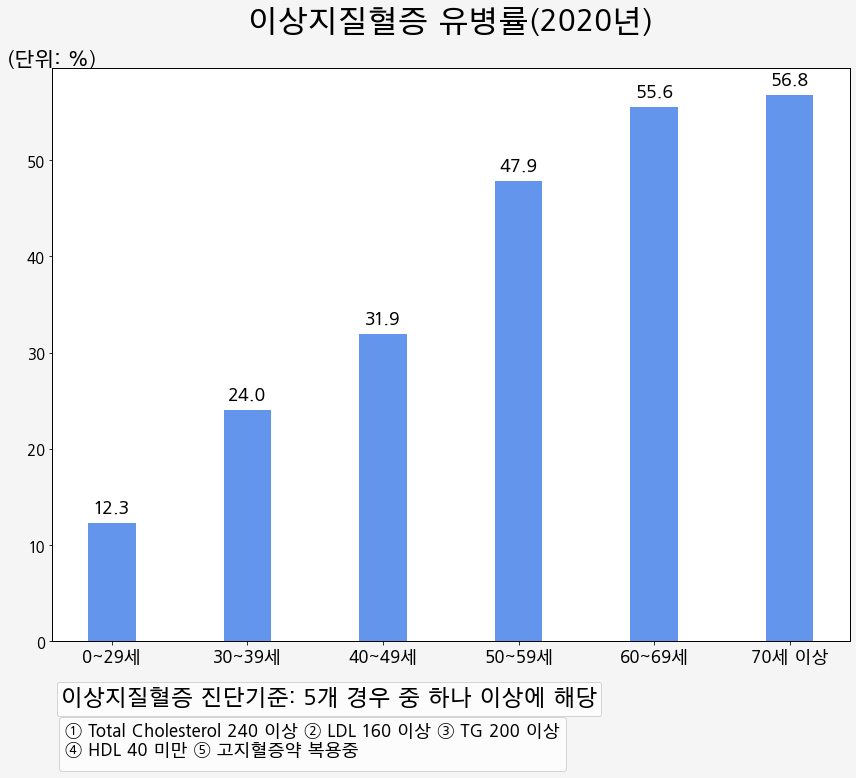

In [19]:
value01 = dysl_per_subt.iloc[0,:-1]


x = np.arange(len(labels))  # the label locations # all 값이 list에는 포함되지 않았기 때문임.
width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12, 11)) # 캔버스 배경 사이즈 설정

fig.set_facecolor('whitesmoke') ## 캔버스 배경색 설정
# rects1 = ax.bar(x,  value01, width, label='전체',color='cornflowerblue')
rects1 = ax.bar(x,  value01, width,color='cornflowerblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('이상지질혈증 유병률(2020년)\n',fontsize=30)
ax.set_ylabel(
                '(단위: %)' # 표시값
                 ,labelpad=-70 # 여백값 설정
                ,fontsize=20 # 글씨크기 설정
                ,rotation=0 # 회전값 조정
#                 ,ha='center' # 위치조정
                ,loc='top' # 위치조정, ha와 동시에 사용은 불가함.
            )
ax.yaxis.set_tick_params(labelsize=15) # y축 표시값 글씨크기 조정
ax.set_xticks(x)
ax.set_xticklabels(
                   labels[0:len(labels)] # all 값이 list에는 포함되지 않았기 때문임.
                  , fontsize=17
                  )

# bar위에 값 label 표시
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(height, 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 8),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom'
                   ,fontsize=18
                   )

autolabel(rects1)

# multiple legend
def twinx(self):
    ax2 = self._make_twin_axes(sharex=self)
    # ax2.yaxis.tick_right()
    ax2.yaxis.set_visible(False)
    # ax2.yaxis.set_label_position('right')
    # ax2.yaxis.set_offset_position('right')
    ax2.set_autoscalex_on(self.get_autoscalex_on())
    self.yaxis.tick_left()
    ax2.xaxis.set_visible(False)
    ax2.patch.set_visible(False)
    return ax2

ax2 = twinx(ax)
ax3 = twinx(ax)
lg1 = ax2.legend(bbox_to_anchor=(0,-0.14), title='이상지질혈증 진단기준: 5개 경우 중 하나 이상에 해당', title_fontsize = 22 ,ncol=1  ,loc='lower left')
lg2 = ax3.legend(bbox_to_anchor=(0,-0.24), title='① Total Cholesterol 240 이상 ② LDL 160 이상 ③ TG 200 이상\n④ HDL 40 미만 ⑤ 고지혈증약 복용중', title_fontsize = 17 ,ncol=1,loc='lower left' ,fontsize=15)

fig.tight_layout()

plt.savefig("{}/dysl_total_t.png".format(workdir)
            ,bbox_extra_artists=(lg1,lg2)
            ,bbox_inches='tight'
            )

# plt.show()

# data merge, export

In [17]:
dysl_agegrp.to_excel('{}/dysl_agegrp.xlsx'.format(workdir))
dysl_agegrp_t.to_excel('{}/dysl_agegrp_t.xlsx'.format(workdir))